# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goshaserbin","key":"1bf5f9b29c4b8aaf933caeda54b78cfa"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c park-spring-2023-music-genre-recognition
!unzip park-spring-2023-music-genre-recognition.zip

In [ ]:
!pip install librosa==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.6 MB/s eta 0:00:00
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201378 sha256=04a557ee8e98e1070770af7e5e61ed1a86900f0846b429aa9b2139bddb32ea36
  Stored in directory: /root/.cache/pip/wheels/bf/b7/85/2f8044306ccec014930aea23ad4852fca9e2584e21c6972bc6
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [ ]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Union

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
plt.style.use("ggplot")

In [ ]:
@dataclass
class Features:
    sample_rate: int = 22050
    hop_length: int = 220
    n_fft: int = 2048
    n_frames_per_example: int = 1


def load_wav(path: Union[str, Path], sample_rate: int) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=sample_rate)
    return waveform


def extract_features(file_path: Union[str, Path], params: Features) -> List[np.ndarray]:
    waveform = load_wav(file_path, sample_rate=params.sample_rate)

    spectrogram = librosa.feature.melspectrogram(
        waveform, n_fft=params.n_fft, hop_length=params.hop_length
    )

    spectrogram = np.log(1e-20 + np.abs(spectrogram**2))

    n_examples = spectrogram.shape[1] // params.n_frames_per_example

    return [
        spectrogram[
            :, i * params.n_frames_per_example : (i + 1) * params.n_frames_per_example
        ].reshape(1, -1)
        for i in range(n_examples)
    ]

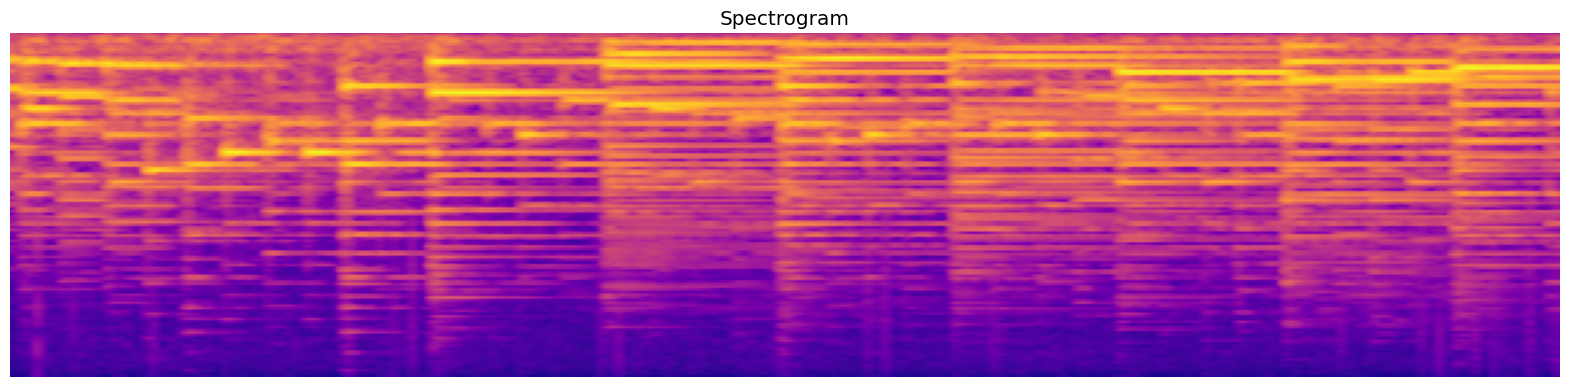

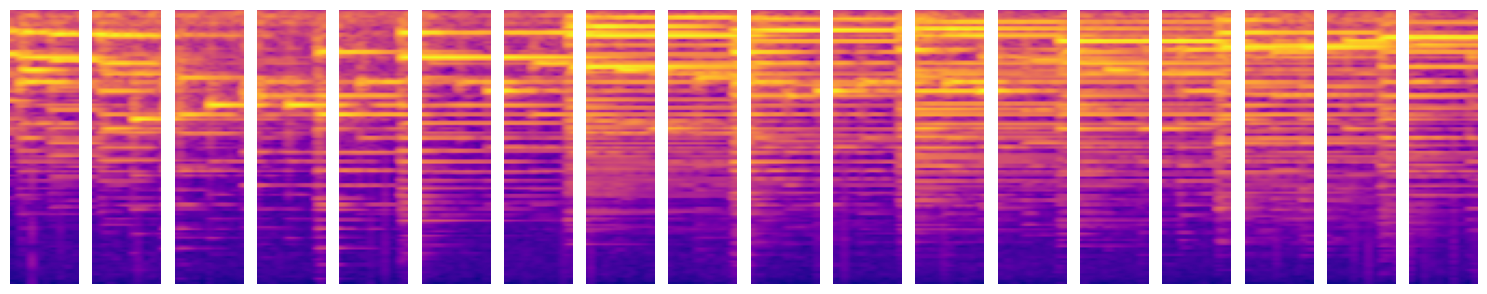

In [ ]:
# 1161154212832220511.wav
# 1429195257218202828.wav

PATH = "./train/train/classical/1429195257218202828.wav"
PARAMS = Features(n_frames_per_example=32)

ipd.display(ipd.Audio(PATH))

sample_features = [
    feature.reshape(-1, PARAMS.n_frames_per_example)
    for feature in extract_features(file_path=PATH, params=PARAMS)
]

plt.figure(figsize=(20, 5))
plt.title("Spectrogram")
plt.imshow(np.hstack(sample_features), cmap="plasma")
plt.axis("off")
plt.savefig("spectrogram.png", dpi=200)
plt.show()

plt.figure(figsize=(20, 5))
for i, feature in enumerate(sample_features):
    plt.subplot(1, len(sample_features) + 1, i + 1)
    plt.imshow(feature, cmap="plasma")
    plt.axis("off")
plt.show()

In [ ]:
def load_folder_data(
    path: Path, train: bool, params: Features
) -> Tuple[List[List[np.ndarray]], List[List[str]], List[Path]]:
    features: List[List[np.ndarray]] = []
    labels: List[List[str]] = []
    file_names: List[Path] = list(path.rglob("*.wav"))

    for file_path in file_names:
        file_features = extract_features(file_path, params)

        features.append(file_features)

        if train:
            class_name = file_path.parent.name
            labels.append([class_name] * len(file_features))

    return features, labels, file_names

In [ ]:
@dataclass
class ExpConfig:
    features: Features = Features(
        sample_rate=22050,
        hop_length=220,
        n_fft=2048,
        n_frames_per_example=1,
    )
    random_state: int = 42
    test_size: float = 0.1
    train_path: Path = Path("./train/train")
    test_path: Path = Path("./test/test")


config = ExpConfig()

In [ ]:
class_names = [folder.name for folder in config.train_path.iterdir()]

class_name2id: Dict[str, int] = {
    class_name: class_id for class_id, class_name in enumerate(class_names)
}

features, labels, file_names = load_folder_data(
    path=config.train_path, train=True, params=config.features
)

labels_int: List[List[int]] = [
    [class_name2id[label] for label in label_list] for label_list in labels
]

In [ ]:
class_names

['reggae',
 'hiphop',
 'country',
 'classical',
 'metal',
 'disco',
 'blues',
 'pop',
 'jazz',
 'rock']

In [ ]:
(
    features_train,
    features_test,
    labels_train,
    labels_test,
    files_train,
    files_test,
) = train_test_split(
    features,
    labels_int,
    file_names,
    random_state=config.random_state,
    test_size=config.test_size,
)

In [ ]:
X_train = np.vstack([x for list_ in features_train for x in list_])
y_train = np.array([x for list_ in labels_train for x in list_])

In [ ]:
X_train.shape

(2438084, 128)

# Baseline

In [ ]:
%%time

pipe = Pipeline([("scaler", StandardScaler()), ("clf", SGDClassifier(loss="log"))]).fit(
    X_train, y_train
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


CPU times: user 3min 28s, sys: 4.44 s, total: 3min 33s
Wall time: 3min 36s


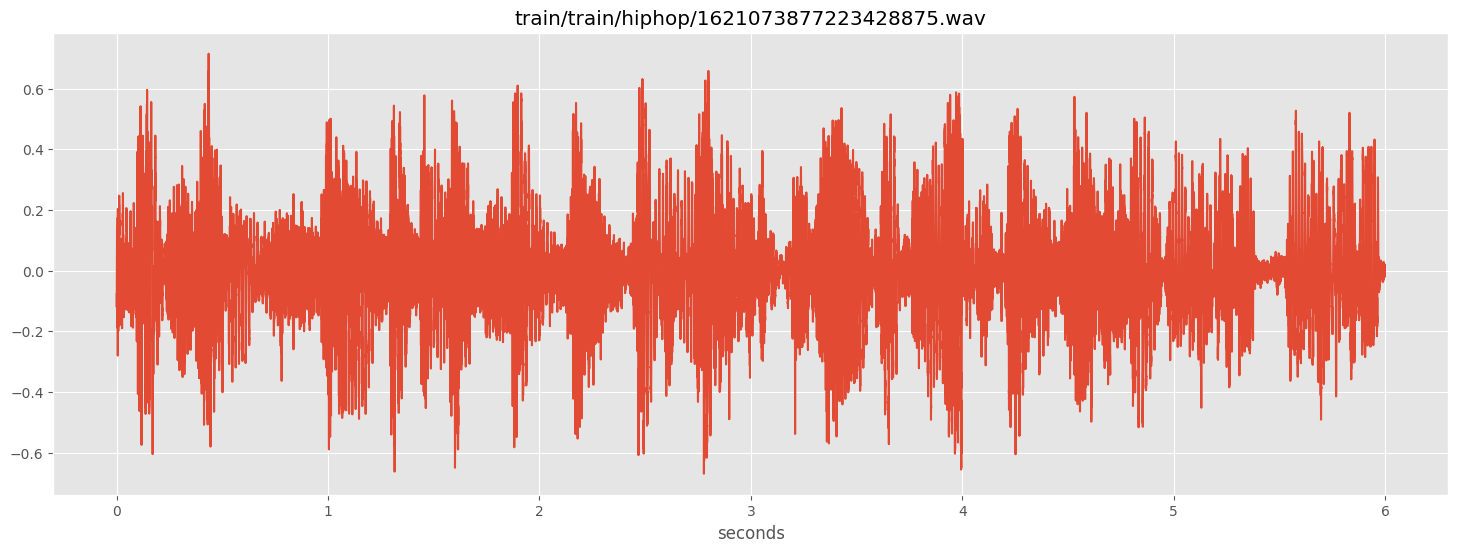

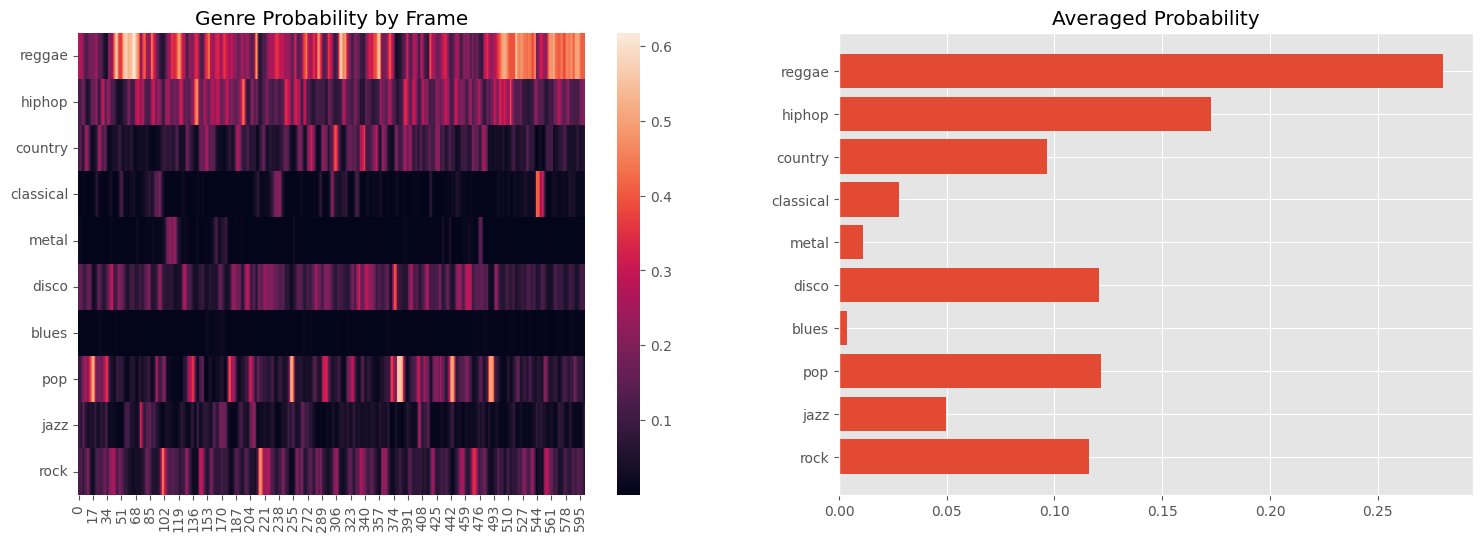

In [ ]:
TEST_ID = 120

predictions = pipe.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def plot_conf_matrix(
    y_test: np.ndarray, y_pred: np.ndarray, class_names: List[str], annot: bool = False
) -> None:
    plt.figure(figsize=(8, 6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.2f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        annot=annot,
    )
    plt.show()

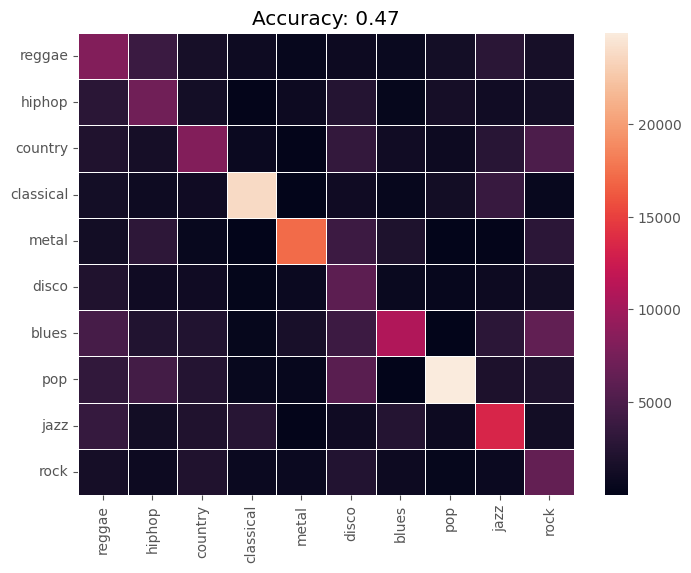

In [ ]:
X_test = np.vstack(
    [feature for feature_list in features_test for feature in feature_list]
)

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

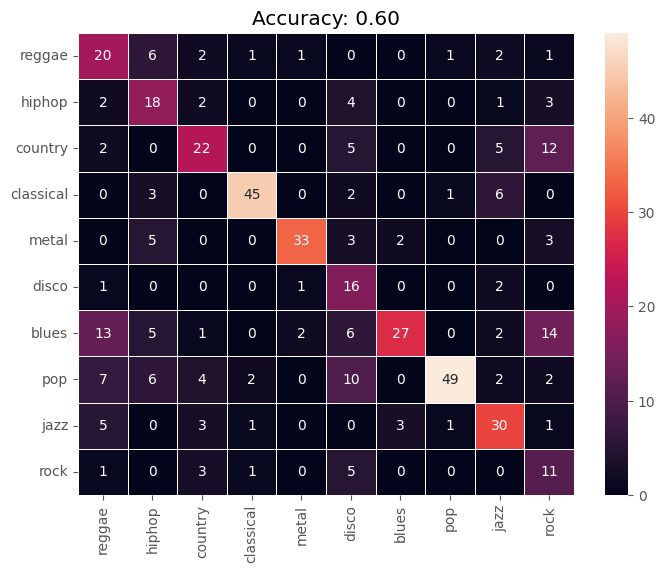

In [ ]:
y_pred = np.array(
    [
        pipe.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [ ]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)

In [ ]:
predictions = [
    class_names[pipe.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]

In [ ]:
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("submit.csv", index=False)
)

# K-neighbors

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
sample = np.random.randint(0, y_train.shape[0], 20000)

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()),("clf", KNeighborsClassifier(n_neighbors=12, n_jobs=4, metric='cosine'))]).fit(
    X_train[sample,:], y_train[sample]
)

In [ ]:
set(y_train[:10000])

{0, 1, 2, 4, 5, 6, 8, 9}

In [ ]:
y_train.shape

(2438084,)

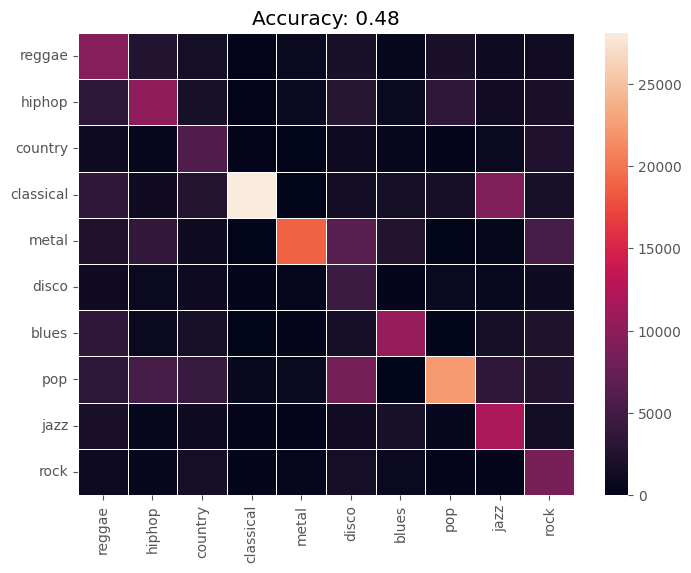

In [ ]:
X_test = np.vstack(
    [feature for feature_list in features_test for feature in feature_list]
)

y_test = np.array([label for label_list in labels_test for label in label_list])

y_pred = pipe.predict(X_test)

plot_conf_matrix(y_pred, y_test, class_names)

Ближайшие соседи позволили чуть повысить скор на одном фрейме, но они требуют очень много времени для распознавания

# Gradient Boosting

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
sample = np.random.randint(0, y_train.shape[0], 10000)

In [ ]:
%%time

boosting = Pipeline([("scaler", StandardScaler()), ("clf", GradientBoostingClassifier(warm_start=True,learning_rate=0.09, n_estimators = 140, subsample=0.7))]).fit(
    X_train[sample, :], y_train[sample]
)

CPU times: user 9min 34s, sys: 701 ms, total: 9min 35s
Wall time: 10min 9s


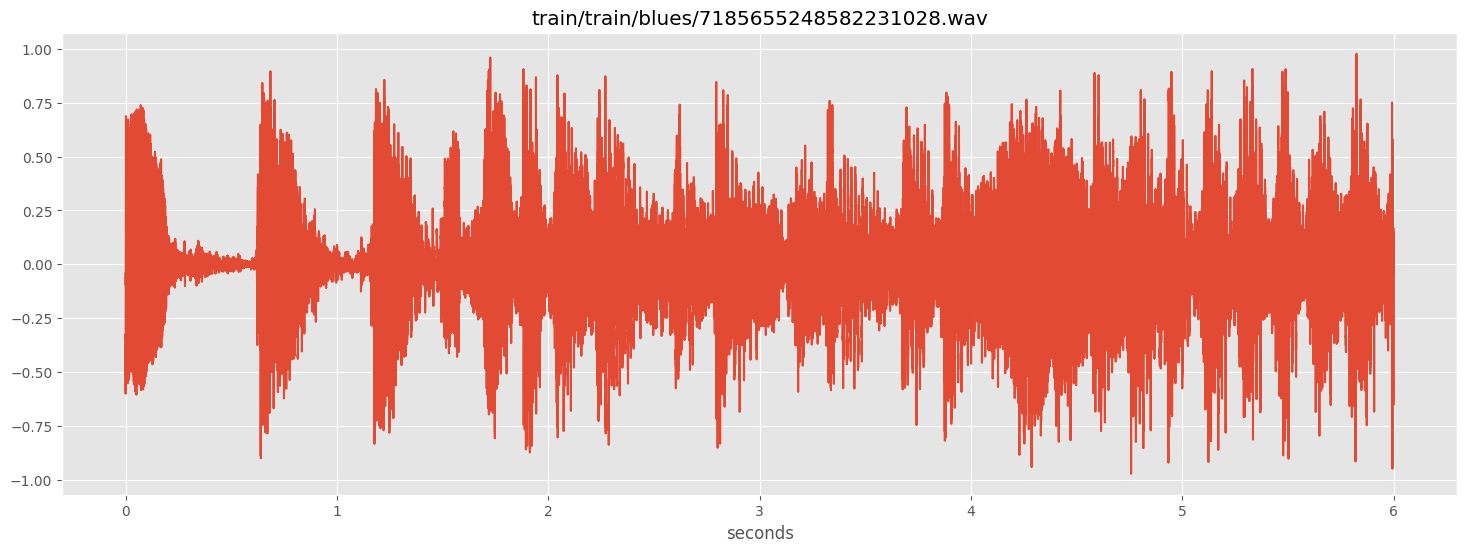

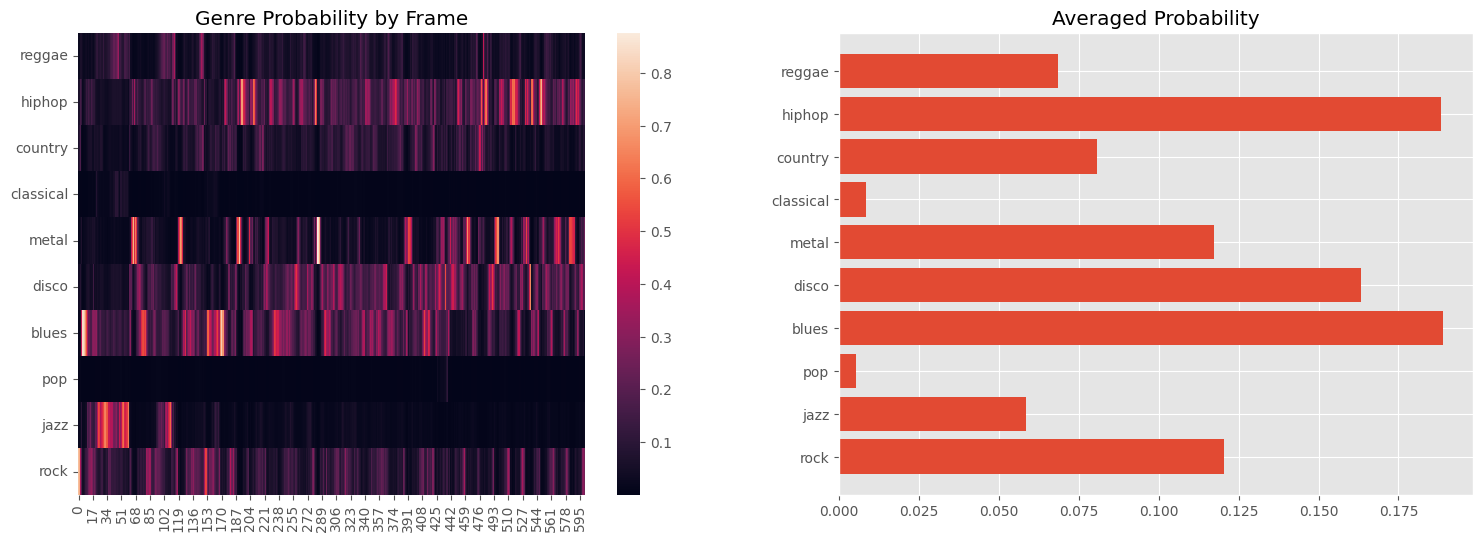

In [ ]:
TEST_ID = 220

predictions = boosting.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(122)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()
plt.show()

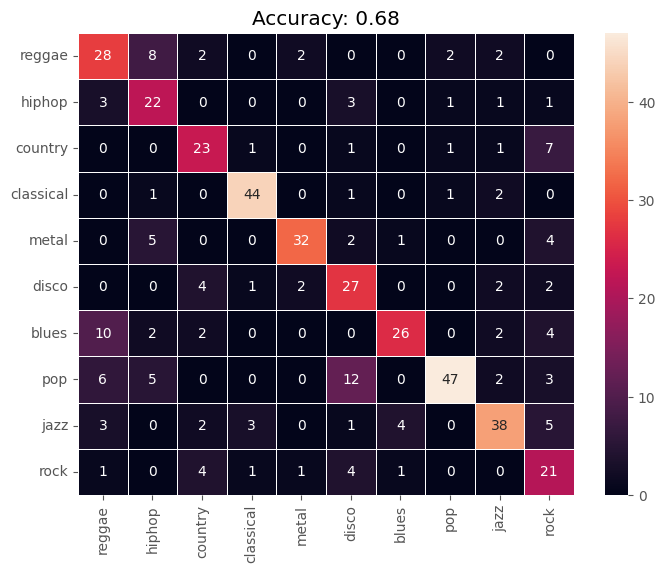

In [ ]:
y_pred = np.array(
    [
        boosting.predict_proba(np.vstack(feature_list)).mean(0).argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [ ]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)
predictions = [
    class_names[boosting.predict_proba(np.vstack(test_feature)).mean(0).argmax()]
    for test_feature in test_features
]
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("boosting2.csv", index=False)
)

# Улучшения

1. Считаем какой наиболее часто предсказываемый жанр в окне. После подсчета нормируем результат

In [ ]:
def most_common_in_window(predictions, window_size=15):
    window_counts = np.zeros(10)
    for i in range(window_size, len(predictions)):
        window = predictions[i-window_size:i]
        counts = np.bincount(window)
        window_counts[np.argmax(counts)] += np.max(counts)
    return window_counts.reshape(-1, 1) / np.linalg.norm(window_counts)

2. Считаем сколько раз модель предсказала один и тот же жанр несколько кадров подряд

In [ ]:
def same_row(predictions, window_size=2):
    window_counts = np.zeros(10)
    for i in range(window_size, len(predictions)):
        window = np.argmax(predictions[i-window_size:i],axis = 1)
        if np.all(window == window[0]):
          window_counts[window[0]] += 1
    return window_counts.reshape(-1, 1) / np.linalg.norm(window_counts)

3. Ядро

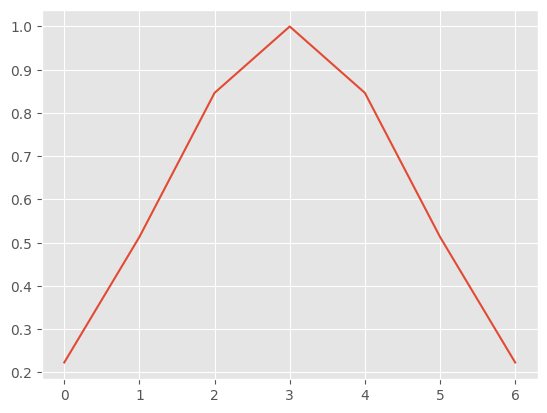

In [ ]:
window_size = 6
kernel = np.array([np.exp(-(i)**2/window_size) for i in range(-window_size//2,window_size//2 + 1)])
plt.plot(kernel)

Находим наиболее вероятноый ответ с учетом того что происходит в окрестности кадра

In [ ]:
def kernel_proba(predictions, window_size=4):
    window_counts = np.zeros(10)
    kernel = np.array([np.exp(-(i)**2/window_size) for i in range(-window_size//2,window_size//2+1)])
    for i in range(window_size//2, len(predictions)-window_size//2):
        window = predictions[i-window_size//2:i+window_size//2+1]
        window_counts[np.argmax(np.dot(kernel,window))] += 1
    return window_counts.reshape(-1, 1) / np.linalg.norm(window_counts)

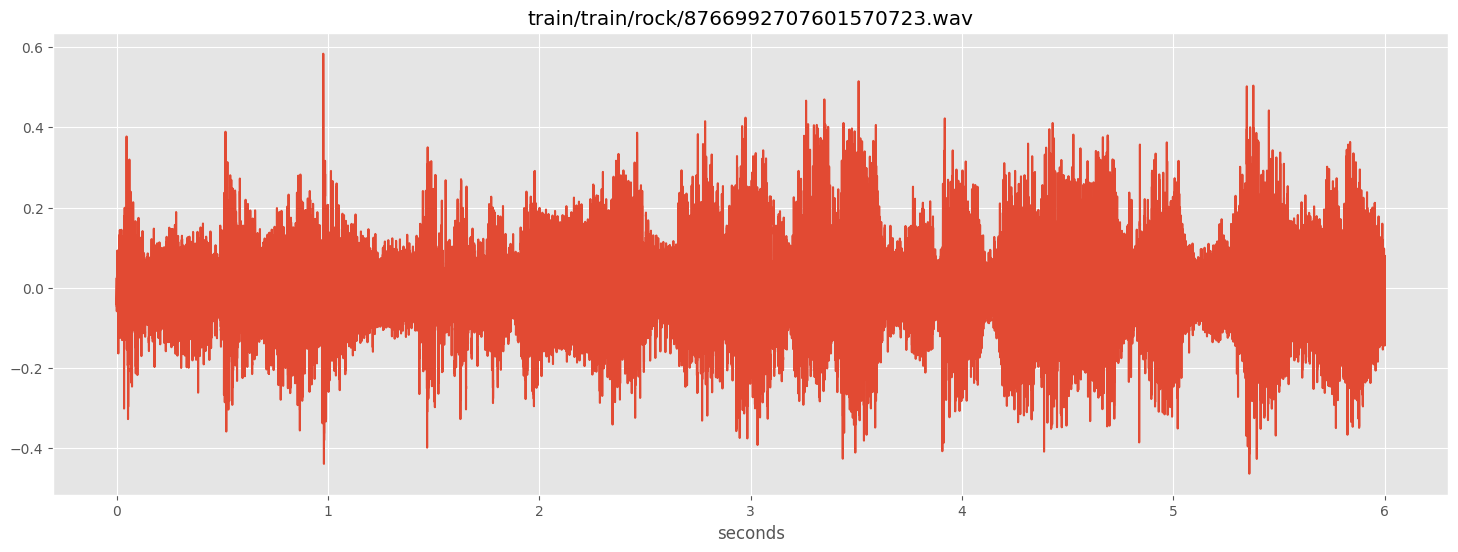

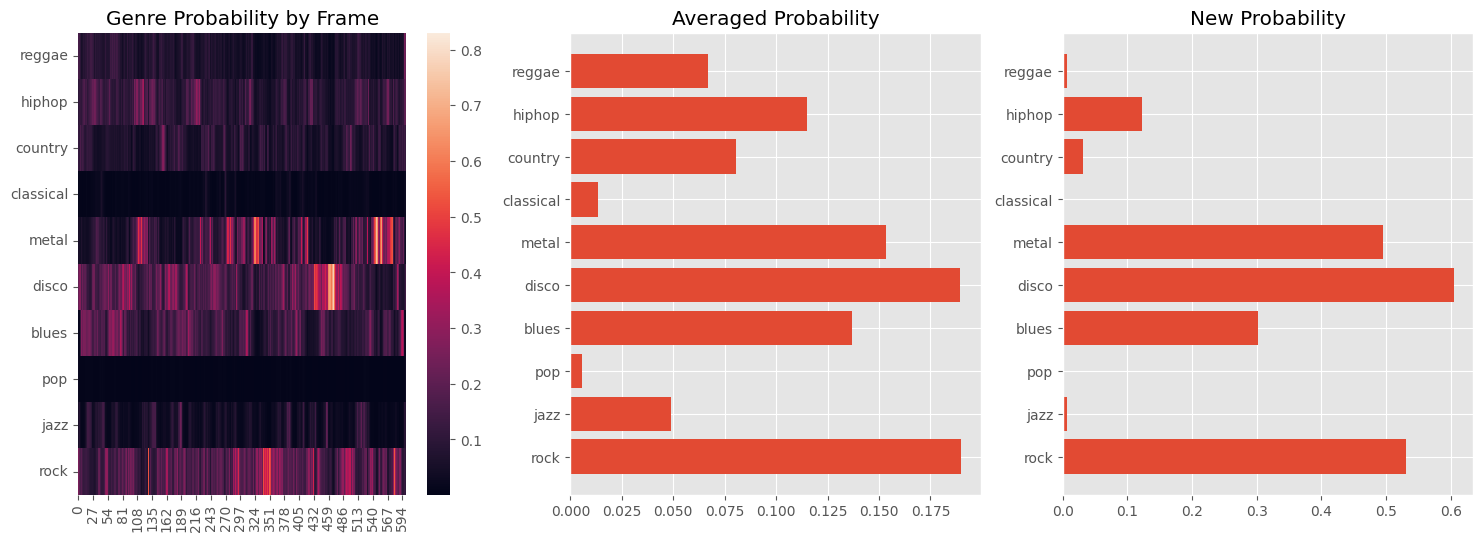

In [ ]:
TEST_ID = 153

predictions = boosting.predict_proba(np.vstack(features_train[TEST_ID]))

plt.figure(figsize=(18, 6))
plt.title(files_train[TEST_ID])
wave_form = load_wav(files_train[TEST_ID], sample_rate=config.features.sample_rate)
time_axis = [x / config.features.sample_rate for x in range(wave_form.size)]
plt.plot(time_axis, wave_form)
plt.xlabel("seconds")
plt.show()

ipd.display(ipd.Audio(files_train[TEST_ID]))
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title("Genre Probability by Frame")
sns.heatmap(predictions.T, yticklabels=class_names)

plt.subplot(132)
plt.title("Averaged Probability")
plt.barh(class_names, predictions.mean(0))
plt.gca().invert_yaxis()

new_predictions = kernel_proba(boosting.predict_proba(np.vstack(features_train[TEST_ID])))
plt.subplot(133)
plt.title("New Probability")
plt.barh(class_names, new_predictions.flatten())
plt.gca().invert_yaxis()
plt.show()

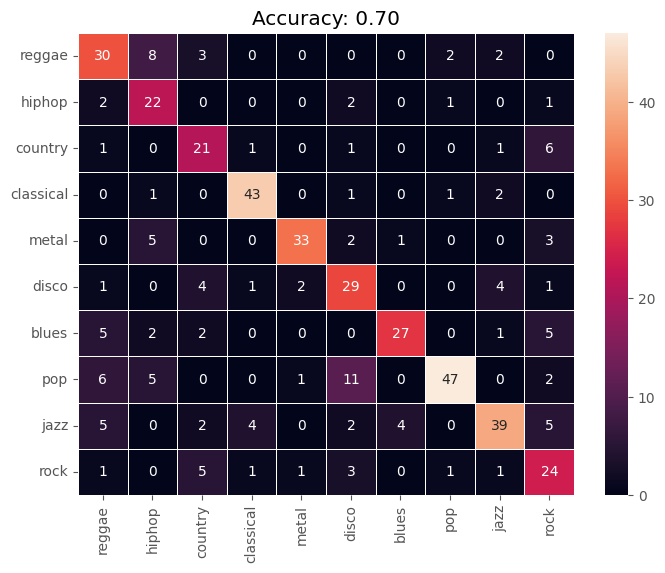

In [ ]:
y_pred = np.array(
    [
        kernel_proba(boosting.predict_proba(np.vstack(feature_list))).flatten().argmax()
        for feature_list in features_test
    ]
)

y_test = np.array([label_list[0] for label_list in labels_test])

plot_conf_matrix(y_pred, y_test, class_names, annot=True)

In [ ]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)
predictions = [
    class_names[kernel_proba(boosting.predict_proba(np.vstack(test_feature))).flatten().argmax()]
    for test_feature in test_features
]
(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("kernel.csv", index=False)
)

# Метамодель

In [ ]:
def get_boosting_proba(features):
  return np.array(
    [
        boosting.predict_proba(np.vstack(feature_list)).mean(0)
        for feature_list in features
    ])

In [ ]:
feature1 = get_boosting_proba(features_train)

In [ ]:
feature1.shape

(4050, 10)

In [ ]:
def get_same_row_proba(features):
  return np.array(
    [
        same_row(boosting.predict_proba(np.vstack(feature_list)))
        for feature_list in features
    ]).reshape(len(features), 10)

In [ ]:
feature2 = get_same_row_proba(features_train)

In [ ]:
feature2.shape

(4050, 10)

In [ ]:
def get_mean(features):
  return np.array(
    [
        np.mean(feature_list)
        for feature_list in features
    ]).reshape(-1,1)

In [ ]:
feature3 = get_mean(features_train)

In [ ]:
feature3.shape

(4050, 1)

In [ ]:
def get_var(features):
  return np.array(
    [
        np.var(feature_list)
        for feature_list in features
    ]).reshape(-1,1)

In [ ]:
feature4 = get_var(features_train)

In [ ]:
feature4.shape

(4050, 1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from collections import Counter

labels_train2 = [Counter(label).most_common(1)[0][0] for label in labels_train]
labels_test2 = [Counter(label).most_common(1)[0][0] for label in labels_test]

In [ ]:
meta = Pipeline([("scaler", StandardScaler()),("clf", KNeighborsClassifier(n_neighbors=12, n_jobs=4, metric='cosine'))]).fit(
    feature1, labels_train2
)

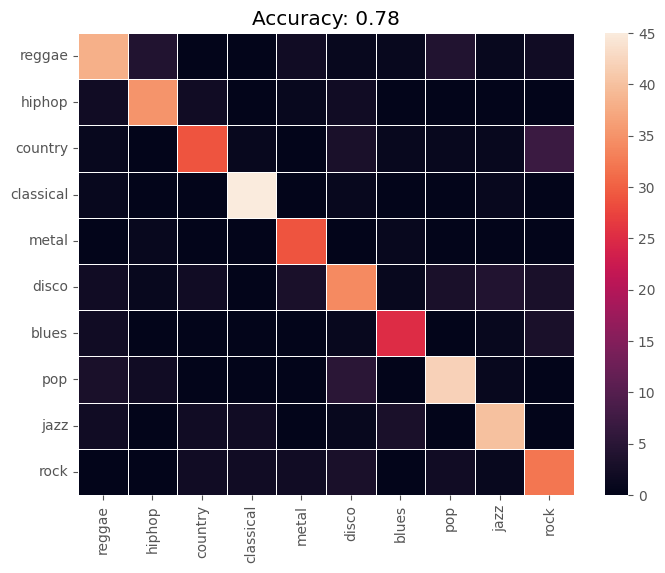

In [ ]:
y_test =labels_test2

y_pred = meta.predict(get_boosting_proba(features_test))

plot_conf_matrix(y_pred, y_test, class_names)

In [ ]:
meta2 = Pipeline([("scaler", StandardScaler()),("clf", KNeighborsClassifier(n_neighbors=35, n_jobs=4,weights='distance'))]).fit(
    np.hstack((feature1,feature3, feature4)), labels_train2
)

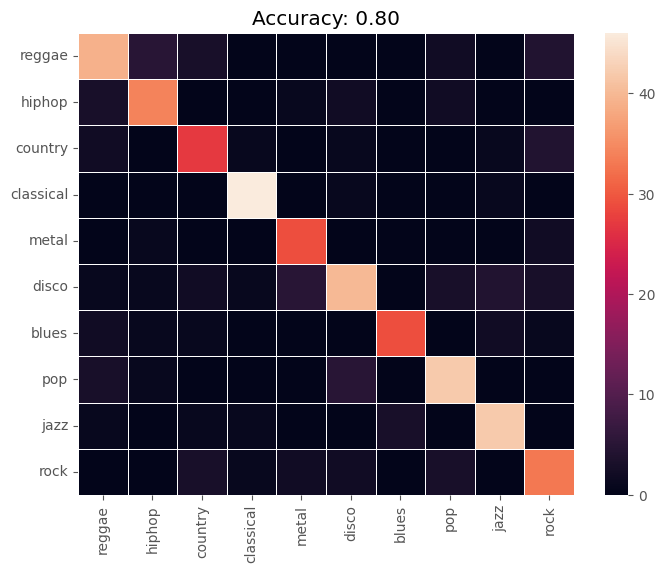

In [ ]:
y_test =labels_test2

y_pred = meta2.predict(np.hstack((get_boosting_proba(features_test),get_mean(features_test),get_var(features_test) )))

plot_conf_matrix(y_pred, y_test, class_names)

In [ ]:
npclass_names = np.array(class_names)

In [ ]:
test_features, _, test_pathes = load_folder_data(
    config.test_path, train=False, params=config.features
)
predictions = npclass_names[meta2.predict(np.hstack((get_boosting_proba(test_features),get_mean(test_features),get_var(test_features) )))]

(
    pd.DataFrame(
        {
            "index": [
                test_wav_path.name for test_wav_path in config.test_path.iterdir()
            ],
            "genre": predictions,
        }
    ).to_csv("meta.csv", index=False)
)